# Market Regime Sniper – Cosine / SSA / UMAP / HDBSCAN Demo

This notebook is a **clean, end‑to‑end demonstration** of the `market_regime_sniper` pipeline.

It shows how to:

1. Load historical index data (S&P 500 daily closes).
2. Build **cosine / norm DCA‑shape features** per year.
3. Smooth them with **Singular Spectrum Analysis (SSA)**.
4. Embed yearly regimes with **UMAP** and cluster them with **HDBSCAN**.
5. Statistically validate **bull / bear regimes**.
6. Run the **Hybrid Sniper** backtest (regime‑aware DCA + volatility scaling).

> The heavy lifting lives in the Python package (`src/market_regime_sniper`).  
> This notebook is only a thin, reproducible example layer on top.


In [1]:
# --- Path setup so we can import the package from ../src ---
import sys
from pathlib import Path

# Notebooks live in: <project_root>/notebooks
PROJECT_ROOT = Path.cwd().parent          # .../sp_mapping
SRC_PATH = PROJECT_ROOT / "src"           # .../sp_mapping/src

if str(SRC_PATH) not in sys.path:
    sys.path.append(str(SRC_PATH))
    print("Added to PYTHONPATH:", SRC_PATH)

# --- Core libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# --- Project imports (clean, package-style) ---
from market_regime_sniper.pipeline import (
    load_spx_from_csv,
    build_cosine_norm_features,
    run_ssa_umap_hdbscan,
    build_clusters_df,
)

from market_regime_sniper.sniper_strategy import (
    run_hybrid_sniper,
    get_regime_ids,
)

from market_regime_sniper.my_stats import ClusterRegimeTester
from market_regime_sniper.plot import RegimeMagnitudePlotter

# --- Plot style ---
plt.style.use("default")
plt.rcParams["figure.figsize"] = (10, 4)

Added to PYTHONPATH: /Users/stayros/Desktop/python/Μαθήματα/Data/sp_mapping/src


## 1. Load S&P 500 data

In [2]:
spx = load_spx_from_csv()
spx.head()

,Open,High,Low,Close,Volume
Date,,,,,
1950-01-03,16.66,16.66,16.66,16.66,700000.0
1950-01-04,16.85,16.85,16.85,16.85,1050000.0
1950-01-05,16.93,16.93,16.93,16.93,1416667.0
1950-01-06,16.98,16.98,16.98,16.98,1116667.0
1950-01-07,17.09,17.09,17.09,17.09,1116667.0


## 2. Build cosine / norm yearly features and annual returns

In [3]:
features, annual = build_cosine_norm_features(spx)
print("Feature matrix shape:", features.shape)
annual.head()

Feature matrix shape: (75, 462)


,first,last,returns
1950,16.66,20.41,22.509004
1951,20.77,23.77,14.443909
1952,23.80,26.57,11.638655
1953,26.54,24.81,-6.518463
1954,24.95,35.98,44.208417


## 3. SSA smoothing + UMAP embedding + HDBSCAN clustering

In [4]:
df_ssa, umap_2d, labels, years_df = run_ssa_umap_hdbscan(features)
years = years_df["year"].astype(int).values

print("SSA-smoothed feature matrix:", df_ssa.shape)
print("UMAP embedding shape:", umap_2d.shape)
print("Unique clusters:", np.unique(labels))

sil = silhouette_score(umap_2d, labels)
print(f"Silhouette score (UMAP space): {sil:.3f}")


/Users/stayros/Desktop/python/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


SSA-smoothed feature matrix: (75, 462)
UMAP embedding shape: (75, 2)
Unique clusters: [0 1 2 3 4]
Silhouette score (UMAP space): 0.915


/Users/stayros/Desktop/python/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/stayros/Desktop/python/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


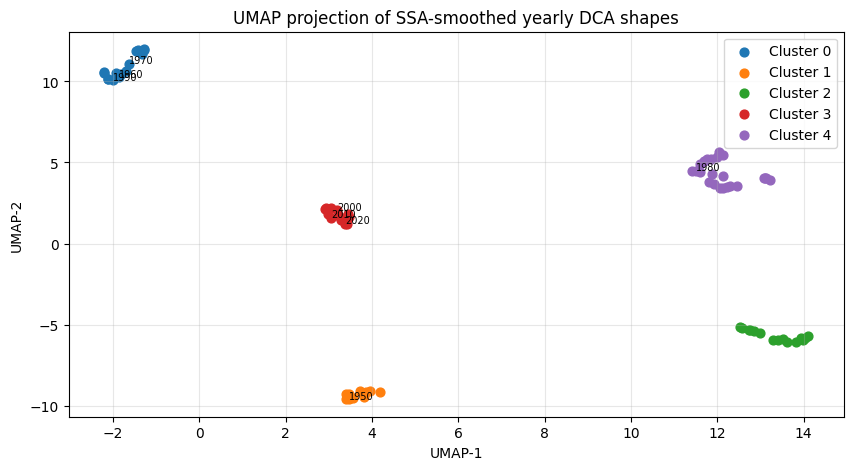

In [5]:
# Quick 2D visualisation of yearly regimes
fig, ax = plt.subplots(figsize=(10, 5))

for lbl in np.unique(labels):
    mask = labels == lbl
    ax.scatter(umap_2d[mask, 0], umap_2d[mask, 1], label=f"Cluster {lbl}", s=40)

# annotate selected years for intuition
for i, yr in enumerate(years):
    if yr % 10 == 0:  # label every 10th year to avoid clutter
        ax.text(umap_2d[i, 0], umap_2d[i, 1], str(yr), fontsize=7)

ax.set_title("UMAP projection of SSA-smoothed yearly DCA shapes")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.grid(alpha=0.3)
ax.legend()
plt.show()

## 4. Build cluster DataFrame and run regime statistics

In [6]:
df_clusters = build_clusters_df(df_ssa.index, labels, annual)
df_clusters.head()

,cluster,returns
1950,1,22.509004
1951,1,14.443909
1952,2,11.638655
1953,0,-6.518463
1954,4,44.208417


In [7]:
tester = ClusterRegimeTester(df_clusters, cluster_col="cluster", value_col="returns")
tester.pretty_print_bull_vs_rest()

pair_res = tester.pairwise_cluster_tests()
pair_df = tester.pairwise_results_df(pair_res)
pair_df.round(3).head()

/Users/stayros/Desktop/python/Μαθήματα/Data/sp_mapping/src/market_regime_sniper/my_stats.py:139: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_result = anderson_ksamp([a, b])


        BULL vs REST – Cluster Regime Tests       
Bull cluster      : 4
Other clusters    : [0, 1, 2, 3]
N (bull / rest)   : 23 / 52
Mean (bull / rest): 25.53% / 2.29%
Sharpe (bull/rest): 3.041 / 0.165

---- Mean & Distribution tests ----
Welch t-test      : t = 8.920,  p = 0.000
Mann–Whitney U    : U = 1141.000,  p = 0.000
Levene (variance) : stat = 8.487, p = 0.005
Cohen's d         : d = 2.022
KS test           : KS = 0.803, p = 0.000
Anderson–Darling  : AD = 27.695, p ≈ 0.001

---- Sharpe / Portfolio-level tests ----
Memmel (Sharpe Δ) : z = 3.372, p = 0.001
GRS (mean eq.)    : F = 36.231, p = 0.000


t_stat   t_p  u_stat    u_p  lev_stat  lev_p  cohen_d  \
cluster_1 cluster_2                                                          
0         1         -10.538  0.00     0.0  0.000     1.945  0.176   -3.978   
          2          -7.463  0.00     3.0  0.000     0.449  0.508   -2.725   
          3          -4.748  0.00    16.0  0.000     0.000  0.996   -1.827   
          4         -12.822  0.00     0.0  0.000     0.307  0.583   -4.330   
1         2           2.816  0.01   119.0  0.016     1.434  0.243    1.086   

                     ks_stat   ks_p  ad_stat   ad_p  memmel_z  memmel_p  \
cluster_1 cluster_2                                                       
0         1            1.000  0.000   12.098  0.001   -26.620     0.000   
          2            0.933  0.000   13.980  0.001    -9.854     0.000   
          3            0.767  0.000    8.584  0.001    -1.867     0.062   
          4            1.000  0.000   18.505  0.001   -22.593     0.000   
1         2            0.600  0.018    3.561  0.012    12.053     0.000   

                     grs_stat  grs_p  sharpe_1  sharpe_2  
cluster_1 cluster_2                                       
0         1            54.676  0.000     -1.44     3.980  
          2            48.273  0.000     -1.44     1.295  
          3            16.463  0.002     -1.44     0.325  
          4           126.623  0.000     -1.44     3.041  
1         2             4.218  0.074      3.98     1.295

## 5. Visualise regime magnitude over time

Regime means (source df):
cluster
0   -14.333376
1    15.807318
2     9.435854
3     2.880995
4    25.534041
Name: returns, dtype: float64

Bull cluster: 4 | Bear cluster: 0


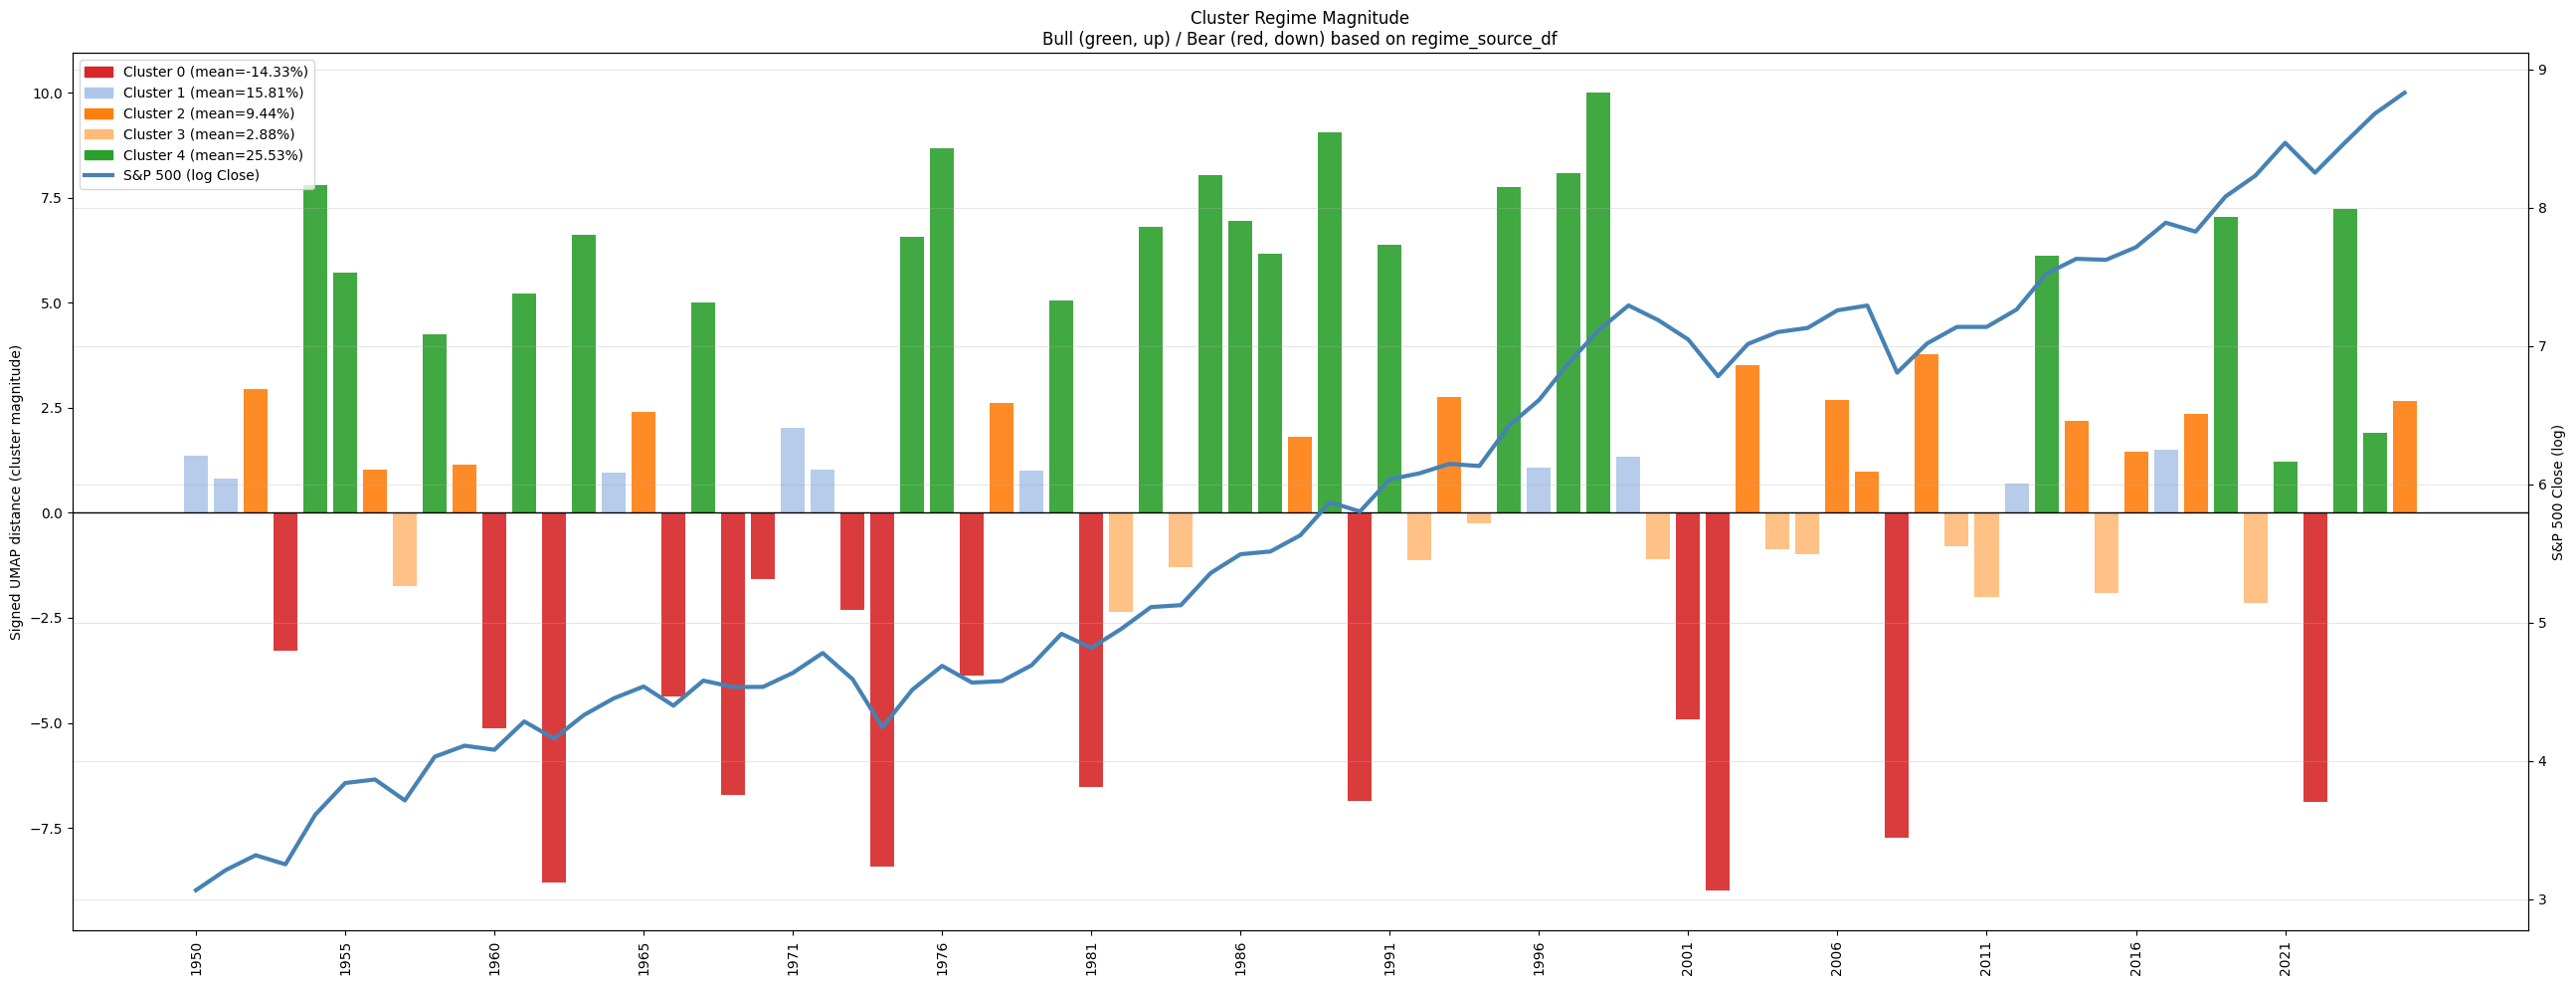

{'bull': np.int64(4),
 'bear': np.int64(0),
 'other': [1, 2, 3],
 'means': cluster
 0   -14.333376
 1    15.807318
 2     9.435854
 3     2.880995
 4    25.534041
 Name: returns, dtype: float64}

In [8]:
plotter = RegimeMagnitudePlotter()
plotter.plot(df_clusters=df_clusters, umap_2d=umap_2d, spx=spx)

## 6. Run Hybrid Sniper backtest (regime-aware DCA)

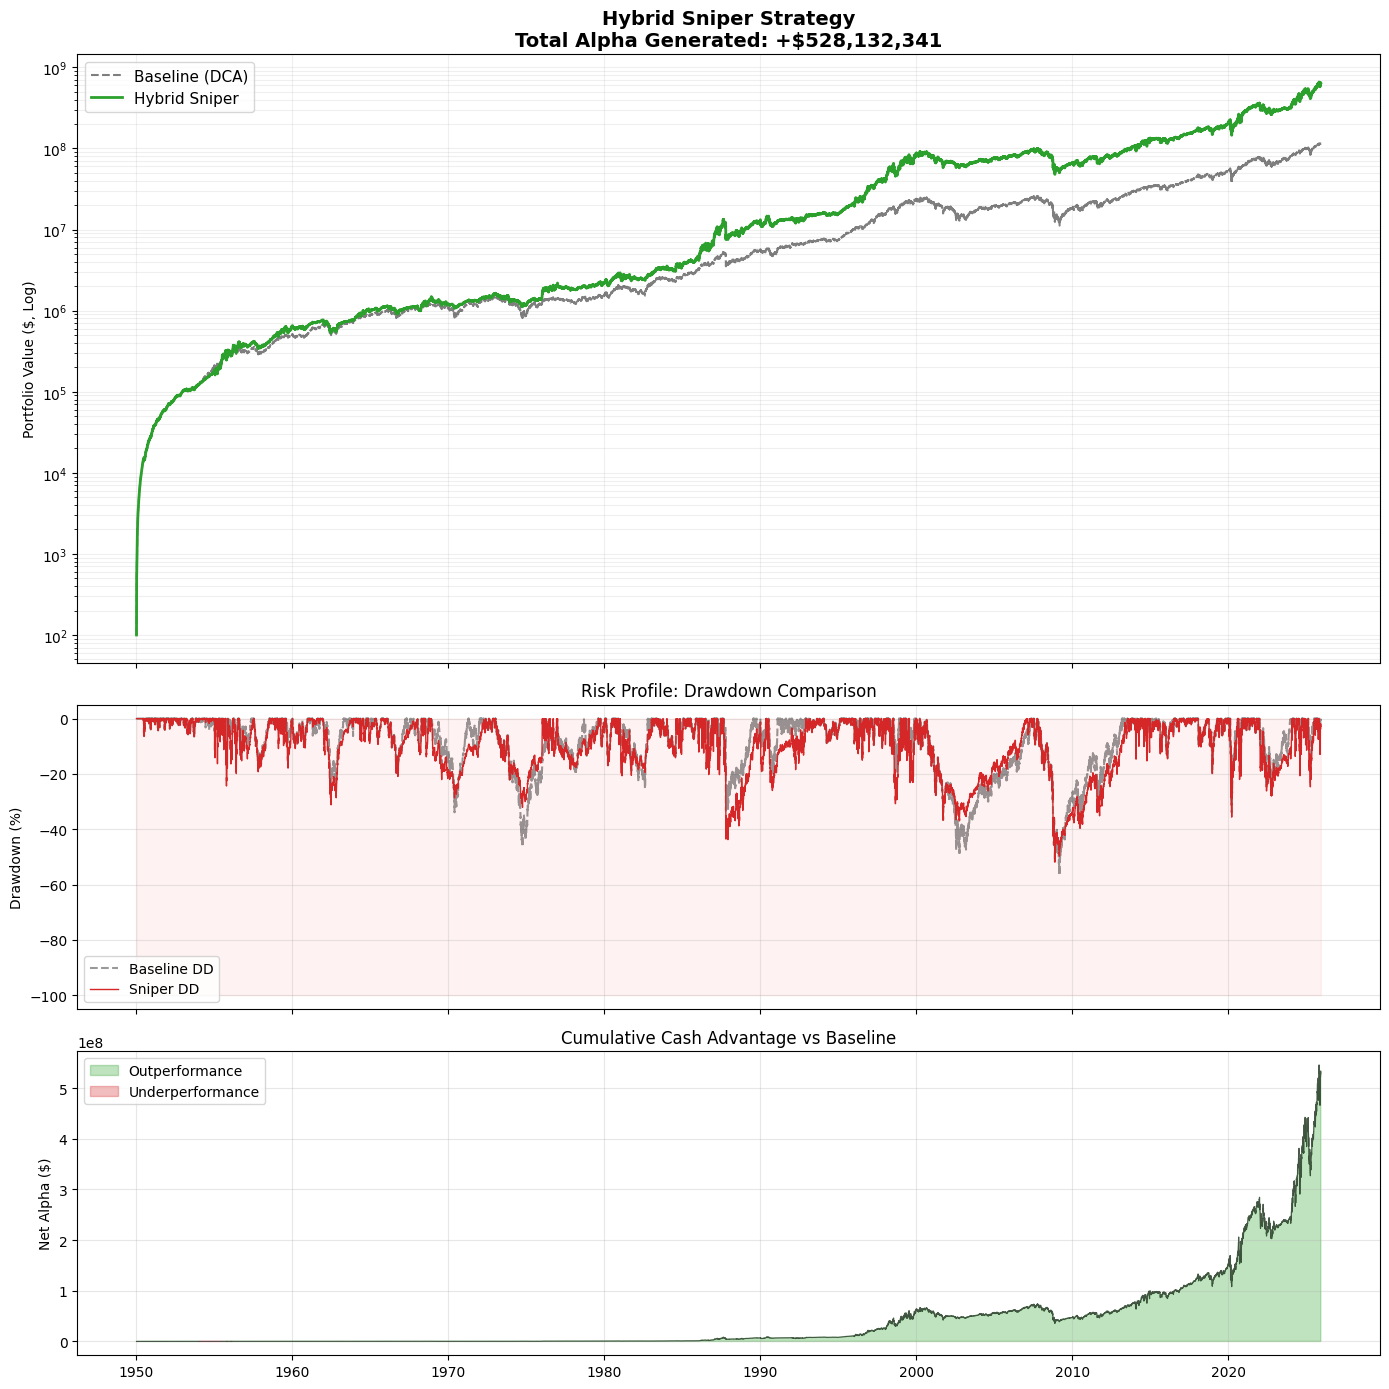

,Final Equity ($),CAGR (%),Max DD (%),Sharpe,Calmar
Strategy,,,,,
Baseline (DCA),1.145122e+08,5.53,-56.69,0.803,0.098
Hybrid Sniper (Vol Scaled),6.426445e+08,7.96,-51.91,0.824,0.153


In [9]:
results = run_hybrid_sniper(
    price_df=spx,
    clusters_df=df_clusters,
    daily_budget=100.0,
    bear_exposure=0.5,
    bull_exposure_base=2.5,
)

results

## 7. Takeaways

Some typical findings you should see when the pipeline is well calibrated:

- One cluster behaves as a **high-Sharpe bull regime**, with clearly higher mean annual returns.
- Another cluster behaves as a **crash / bear regime**, with strongly negative returns.
- UMAP + HDBSCAN recover **macro market phases** (e.g., 1970s stagflation, dot-com bubble, GFC, post-2009 bull).  
- The **Hybrid Sniper** strategy:
  - Preserves the simplicity of DCA (constant cash flow),
  - But reallocates exposure according to detected regimes and volatility,
  - Often achieving **higher CAGR** and **better Calmar** vs. pure DCA in long backtests.

For more details, see the project README and the source modules under `src/market_regime_sniper`.
